***Import Modules***

In [307]:
import pandas as pd
import numpy as np
from pyts.decomposition import SSA
from sklearn import svm
from sklearn.decomposition import PCA
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from scipy import stats
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import matplotlib.pyplot as plt
import itertools
import os

***Load in data for various companies***

In [312]:
#Companies: AAPL GOOG, FB, IBM, BB, MSFT, SAMSUNG
dataframes = [pd.read_csv('AAPL10YEAR.csv'), pd.read_csv('GOOG10YEAR.csv'), pd.read_csv('FB10YEAR.csv'), pd.read_csv('IBM10YEAR.csv'), pd.read_csv('BB10YEAR.csv'), pd.read_csv('MSFT10YEAR.csv'), pd.read_csv('SAMSUNG10YEAR.csv')]
data = [df.values for df in dataframes]


***Feature engineering and train test split***

In [3]:
#REQUIREMENTS: LONG_MA_LENGTH > SHORT_MA_LENGTH (Important Note: the inequality is strict).
#              LONG_MA_LENGTH >= MOMENTUM_PERIOD
#              LONG_MA_LENGTH >= VOLUME_PERIOD

DAYS_AHEAD = 90 #How far ahead you are predicting
SHORT_MA_LENGTH = 14
LONG_MA_LENGTH = 90
MOMENTUM_PERIOD = 14
VOLUME_PERIOD = 30

train_data = np.array([]).reshape(0,9) #Second value equals number of features
test_data = np.array([]).reshape(0,9)
for company in data:
    company_data = []
    closes = (company.T)[4]
    
    company_data.append(closes[LONG_MA_LENGTH:company.shape[0]-DAYS_AHEAD])
    
    #Get Short-Term Moving Averages
    mas = []
    for i in range(LONG_MA_LENGTH-1, company.shape[0]-DAYS_AHEAD):
        ma = sum([closes[j] for j in range(i-SHORT_MA_LENGTH+1, i)])/SHORT_MA_LENGTH #average close of last SHORT_MA_LENGTH days
        mas.append(ma)
    mas = np.array(mas)
    company_data.append(mas[1:])
    
    #Get Changes in Short-Term Moving Average
    delta_mas = []
    for i in range(company.shape[0]-LONG_MA_LENGTH-DAYS_AHEAD):
        delta_mas.append(mas[i+1]-mas[i]) #todays MA minus yesterdays MA
    delta_mas = np.array(delta_mas)
    company_data.append(delta_mas)
    
    #Get Long-Term Moving Averages
    mas = []
    for i in range(LONG_MA_LENGTH-1, company.shape[0]-DAYS_AHEAD):
        ma = sum([closes[j] for j in range(i-LONG_MA_LENGTH+1, i)])/LONG_MA_LENGTH #average close of last LONG_MA_LENGTH days
        mas.append(ma)
    mas = np.array(mas)
    company_data.append(mas[:-1])
    
    #Get Changes in Long-Term Moving Average
    delta_mas = []
    for i in range(company.shape[0]-LONG_MA_LENGTH-DAYS_AHEAD):
        delta_mas.append(mas[i+1]-mas[i]) #todays MA minus yesterdays MA
    delta_mas = np.array(delta_mas)
    company_data.append(delta_mas)
    
    #Get Momentums
    momentums = []
    for i in range(LONG_MA_LENGTH, company.shape[0]-DAYS_AHEAD):
        momentum = closes[i] - closes[i - MOMENTUM_PERIOD]
        momentums.append(momentum)
    momentums = np.array(momentums)
    company_data.append(momentums)
    
    #Get RSI
    RSIs = []
    for i in range(LONG_MA_LENGTH, company.shape[0]-DAYS_AHEAD):
        up_closes = [closes[j] for j in range(i-MOMENTUM_PERIOD, i) if closes[j] > closes[j-1]]
        down_closes = [closes[j] for j in range(i-MOMENTUM_PERIOD, i) if closes[j] < closes[j-1]]
        try:
            RS = (sum(up_closes) * len(down_closes)) / (sum(down_closes) * len(up_closes))
        except ZeroDivisionError:
            RS = 0
        RSI = 100 - 100 / (1 + RS)
        RSIs.append(RSI)
    RSIs = np.array(RSIs)
    company_data.append(RSIs)
    
    #Get Volumes
    volumes = []
    for i in range(LONG_MA_LENGTH, company.shape[0]-DAYS_AHEAD):
        volume = sum(company.T[-1][i-VOLUME_PERIOD:i]) / VOLUME_PERIOD
        volumes.append(volume)
    volumes = np.array(volumes)
    company_data.append(volumes)
    
    #Get directions
    directions = []
    for i in range(LONG_MA_LENGTH, company.shape[0]-DAYS_AHEAD):
        diff = closes[i+DAYS_AHEAD] - closes[i]
        if diff > 0:
            directions.append('up') #increase in price
        else:
            directions.append('down') #decrease in price
    directions = np.array(directions)
    company_data.append(directions)
    
    company_data = np.array(company_data).T
    
    
    #Train Test Split
    length = company_data.shape[0]
    test_data = np.vstack((test_data, company_data[int(0.8*length):]))
    train_data = np.vstack((train_data, company_data[:int(0.8*length)]))
    

In [4]:
data[0]

array([['2014-03-21', 75.989998, 76.25, ..., 76.12428299999999,
        67.315308, 93511600],
       ['2014-03-24', 76.91714499999999, 77.214287, ...,
        77.02714499999999, 68.113724, 88925200],
       ['2014-03-25', 77.35714, 77.964287, ..., 77.855713, 68.846397,
        70573300],
       ...,
       ['2019-03-19', 188.350006, 188.990005, ..., 186.529999,
        186.529999, 31646400],
       ['2019-03-20', 186.229996, 189.490005, ..., 188.16000400000001,
        188.16000400000001, 31035200],
       ['2019-03-21', 190.020004, 196.330002, ..., 195.08999599999999,
        195.08999599999999, 50980100]], dtype=object)

In [5]:
train_data.shape, test_data.shape

((5989, 9), (1499, 9))

***Scaling and Oversampling***

In [6]:
train_xs = train_data.T[:-1].T
train_ys = train_data.T[-1]
scaler = StandardScaler()
train_xs = scaler.fit_transform(train_xs.astype(np.float))

test_xs = test_data.T[:-1].T
test_ys = test_data.T[-1]
test_xs = scaler.fit_transform(test_xs.astype(np.float))

smote = SMOTE(random_state = 1729)
train_xs, train_ys = smote.fit_resample(train_xs, train_ys)

***Train Model***

In [7]:
clf = svm.SVC(C = 1, gamma = 'scale', kernel = 'rbf', random_state = 42, probability = True, cache_size = 1000)
clf.fit(train_xs, train_ys)

SVC(C=1, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

***Get Accuracy (current: accuracy = 62%, up: recall = 59%, precision = 63%, f1 = 61%, down: recall = 66%, precision = 62%, f1 = 64%)***

In [8]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print('down pred:', len([i for i in pred if i == 'down']), 'up pred:', len([i for i in pred if i == 'up']))
print('down test:', len([i for i in test_ys if i == 'down']), 'up test:', len([i for i in test_ys if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))

down pred: 790 up pred: 709
down test: 889 up test: 610
Out of a total of 1499 samples, 920 were correct


***Plot Confusion Matrix***

Normalized confusion matrix
[[0.61867267 0.38132733]
 [0.39344262 0.60655738]]


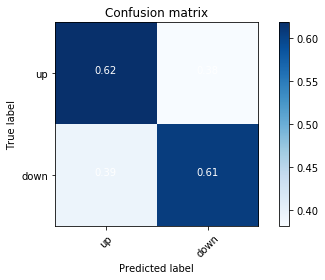

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)

***Precision-Recall Curve (with validation data)***

Average precision-recall score: 0.50


Text(0.5,1,'2-class Precision-Recall curve: AP=0.50')

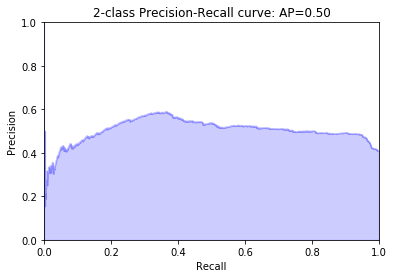

In [10]:
y_score = clf.predict_proba(test_xs).T[1]
average_precision = average_precision_score(test_ys, y_score, pos_label = 'up')
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, thresholds = precision_recall_curve(test_ys, y_score, pos_label = 'up')
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [11]:
probabilities = clf.predict_proba(test_xs).T[1]
np.mean(probabilities), np.std(probabilities)

(0.5301692654965982, 0.20429058420326016)

***Accuracies when probability is at least 1 SD away from the mean***

down pred: 367 up pred: 427
down test: 498 up test: 296
Out of a total of 794 samples, 551 were correct
Normalized confusion matrix
[[0.62449799 0.37550201]
 [0.18918919 0.81081081]]


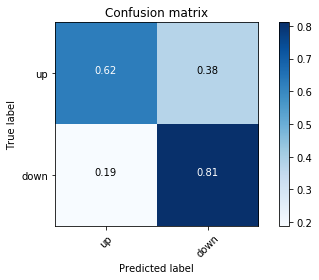

In [12]:
conf_preds = []
conf_test = []
for i in range(len(probabilities)):
    proba = probabilities[i]
    if abs(proba - np.mean(probabilities)) >= np.std(probabilities):
        conf_preds.append(pred[i])
        conf_test.append(test_ys[i])
conf_preds = np.array(conf_preds); conf_test = np.array(conf_test)
total = conf_test.shape[0]
correct = len([x for x in conf_preds==conf_test if x==True])
print('down pred:', len([i for i in conf_preds if i == 'down']), 'up pred:', len([i for i in conf_preds if i == 'up']))
print('down test:', len([i for i in conf_test if i == 'down']), 'up test:', len([i for i in conf_test if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))

cnf_matrix = confusion_matrix(conf_test, conf_preds)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)


***An alternate approach: use many lag variables and reduce dimensions with PCA***

In [339]:
#Short-term trading:
#DAYS_AHEAD = 7
#FEATURES = 14
#MEAN_LENGTH = 2
#JUMP = 1
#n_components = 14

#Mid-term trading:
#DAYS_AHEAD = 90
#FEATURES = 90
#MEAN_LENGTH = 10
#JUMP = 3
#n_components = 10

DAYS_AHEAD = 90
FEATURES = 90
MEAN_LENGTH = 10
JUMP = 3

complete_data = np.array([]).reshape((0, FEATURES // JUMP))
labels = np.array([])

new_data = []
for company in data:
    new_data.append(company[int(0*company.shape[0]):int(0.5*company.shape[0])])

#First process the first 80% of each company's data. This will be the train set.
for company in new_data:
    length = company.shape[0] - DAYS_AHEAD - FEATURES - MEAN_LENGTH
    closes = (company.T)[4]
    
    #Smooth using running mean   
    closes = np.convolve(closes, np.ones((MEAN_LENGTH,))/MEAN_LENGTH, mode='valid')
    
    company_data = []
    for i in range(FEATURES+MEAN_LENGTH, int(0.8*length)+FEATURES):
        company_data.append(closes[i - FEATURES : i : JUMP])
    company_data = np.array(company_data)
    scaler = StandardScaler()
    company_data = scaler.fit_transform(company_data.astype(np.float))
    complete_data = np.vstack((complete_data, company_data))
    
    directions = []
    for i in range(FEATURES+MEAN_LENGTH, int(0.8*length)+FEATURES):
        diff = closes[i+DAYS_AHEAD] - closes[i]
        if diff > 0:
            directions.append('up') #increase in price
        else:
            directions.append('down') #decrease in price
    directions = np.array(directions)
    
    labels = np.concatenate((labels, directions), axis = None)
    
#Now process the remaining 20% (test data)
for company in new_data:
    length = company.shape[0] - DAYS_AHEAD - FEATURES - MEAN_LENGTH
    closes = (company.T)[4]
    
    #Smooth using running mean   
    closes = np.convolve(closes, np.ones((MEAN_LENGTH,))/MEAN_LENGTH, mode='valid')
    
    company_data = []
    for i in range(int(0.8*length)+FEATURES, (company.shape[0] - DAYS_AHEAD - MEAN_LENGTH - 1)):
        company_data.append(closes[i - FEATURES : i : JUMP])
    company_data = np.array(company_data)
    scaler = StandardScaler()
    company_data = scaler.fit_transform(company_data.astype(np.float))
    complete_data = np.concatenate((complete_data, company_data))
    
    directions = []
    for i in range(int(0.8*length)+FEATURES, (company.shape[0] - DAYS_AHEAD - MEAN_LENGTH - 1)):
        diff = closes[i+DAYS_AHEAD] - closes[i]
        if diff > 0:
            directions.append('up') #increase in price
        else:
            directions.append('down') #decrease in price
    directions = np.array(directions)
    
    labels = np.concatenate((labels, directions), axis = None)

#Apply PCA
pca = PCA(n_components = 10, random_state = 1729)
transformed_data = pca.fit_transform(complete_data)
print(np.sum(pca.explained_variance_ratio_))

0.9978306170167441


In [341]:
train_xs = transformed_data[:int(0.8*transformed_data.shape[0])]
train_ys = labels[:int(0.8*transformed_data.shape[0])]

test_xs = transformed_data[int(0.8*transformed_data.shape[0]):]
test_ys = labels[int(0.8*transformed_data.shape[0]):]

smote = SMOTE(random_state = 1729)
train_xs, train_ys = smote.fit_resample(train_xs, train_ys)

In [343]:
MODEL = 'SVC'

if MODEL == 'SVC':
    clf = svm.SVC(C = 5, gamma = 'scale', kernel = 'rbf', random_state = 42, probability = True, cache_size = 1000)
elif MODEL == 'GBC':
    clf = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 1000, random_state = 42)

clf.fit(train_xs, train_ys)


SVC(C=5, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

***Current: accuracy = 65%, up: recall = 73%, precision = 61%, f1 = 66%, down: recall = 53%, precision = 66%, f1 = 59%***

down pred: 699 up pred: 633
down test: 489 up test: 843
Out of a total of 1332 samples, 842 were correct
Normalized confusion matrix
[[0.71370143 0.28629857]
 [0.41518387 0.58481613]]


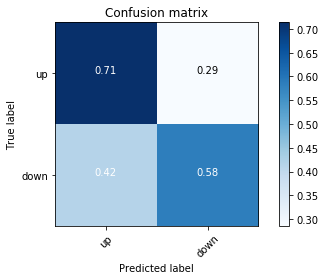

In [344]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print('down pred:', len([i for i in pred if i == 'down']), 'up pred:', len([i for i in pred if i == 'up']))
print('down test:', len([i for i in test_ys if i == 'down']), 'up test:', len([i for i in test_ys if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))
cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)

In [337]:
probabilities = clf.predict_proba(test_xs).T[1]
np.mean(probabilities), np.std(probabilities)

(0.6236737379001178, 0.3485893469871866)

***Statistical Tests of Model Performance***

In [349]:
#Statistical tests for mid-term trading
up_prec_random = np.array([0.5/1.01, 0.49, 0.54/1.04, 0.55/1.05, 0.52/1.02, 0.5])
up_prec_always_up = np.array([843/1332, 845/1333, 639/1332, 1165/1333, 1134/1332, 471/1333])
up_prec_trend = np.array([0.67/1.08, 0.61/1.06, 0.58/0.96, 0.74/1.21, 0.63/1.08, 0.57/0.9])
up_prec_svc = np.array([0.71/1.13, 0.31/0.54, 0.55/0.93, 0.54/0.95, 0.61, 0.74/1.03])
print("result for up precisions against always up:", stats.ttest_rel(up_prec_always_up, up_prec_svc)) #failure to reject H0 (p = 0.78)
print("result for up precisions against random:", stats.ttest_rel(up_prec_random, up_prec_svc)) #reject H0 (p < 0.01)
print("result for up precisions against trend:", stats.ttest_rel(up_prec_trend, up_prec_svc)) #failure to reject H0 (p = 0.58)
print(" ")

down_prec_random = np.array([0.5/0.99, 0.51, 0.5/0.96, 0.5/0.95, 0.5/0.98, 0.5])
down_prec_always_down = np.array([489/1332, 488/1333, 693/1332, 168/1333, 198/1332, 862/1333])
down_prec_trend = np.array([0.58/0.84, 0.77/1.46, 0.62/1.04, 0.53/0.79, 0.55/0.92, 0.67/1.1])
down_prec_svc = np.array([0.6/0.84, 0.77/1.56, 0.62/1.07, 0.59/1.05, 0.61, 0.71/0.97])
print("result for down precisions against always down:", stats.ttest_rel(down_prec_always_down, down_prec_svc)) #reject H0 (p = 0.02)
print("result for down precisions against random:", stats.ttest_rel(down_prec_random, down_prec_svc)) #reject H0 (p = 0.04)
print("result for down precisions against trend:", stats.ttest_rel(down_prec_trend, down_prec_svc)) #failure to reject H0 (p = 0.95)
print(" ")
print("*********************************************************************************************************************")
print(" ")

#Statistical tests for short-term trading
up_prec_random = np.array([0.49/0.99, 0.5, 0.52/1.05, 0.5/1.01, 0.51/0.98, 0.51/1.01])
up_prec_always_up = np.array([850/1577, 829/1578, 786/1577, 941/1578, 904/1577, 862/1578])
up_prec_trend = [0.53, 0.53/0.99, 0.49/0.95, 0.57/1.01, 0.53/1.01, 0.56/1.07]
up_prec_svc = np.array([0.52/0.98, 0.58/1.02, 0.61/1.05, 0.44/0.85, 0.51/0.96, 0.52/0.89])
print("result for up precisions against always up:", stats.ttest_rel(up_prec_always_up, up_prec_svc)) #failure to reject H0 (p = 0.77)
print("result for up precisions against random:", stats.ttest_rel(up_prec_random, up_prec_svc)) #reject H0 (p < 0.01)
print("result for up precisions against trend:", stats.ttest_rel(up_prec_trend, up_prec_svc)) #failure to reject H0 (p = 0.29)
print(" ")

down_prec_random = np.array([0.49/1.01, 0.5, 0.47/0.95, 0.49/0.99, 0.53/1.02, 0.5/0.99])
down_prec_always_down = np.array([727/1577, 749/1578, 791/1577, 637/1578, 673/1577, 716/1578])
down_prec_trend = [0.53, 0.54/1.01, 0.54/1.05, 0.56/0.99, 0.53/0.99, 0.49/0.93]
down_prec_svc = np.array([0.54/1.02, 0.56/0.98, 0.56/0.95, 0.59/1.15, 0.55/1.04, 0.63/1.11])
print("result for down precisions against always down:", stats.ttest_rel(down_prec_always_down, down_prec_svc)) #reject H0 (p < 0.01)
print("result for down precisions against random:", stats.ttest_rel(down_prec_random, down_prec_svc)) #reject H0 (p < 0.01)
print("result for down precisions against trend:", stats.ttest_rel(down_prec_trend, down_prec_svc)) #failure to reject H0 (p = 0.43)


result for up precisions against always up: Ttest_relResult(statistic=0.22496481899564785, pvalue=0.8309117233225216)
result for up precisions against random: Ttest_relResult(statistic=-4.3496011607267695, pvalue=0.007361968043482674)
result for up precisions against trend: Ttest_relResult(statistic=-0.5877671640890262, pvalue=0.5822300354953134)
 
result for down precisions against always down: Ttest_relResult(statistic=-3.3856145384669665, pvalue=0.01955434373271711)
result for down precisions against random: Ttest_relResult(statistic=-2.559621866763285, pvalue=0.05066986904723086)
result for down precisions against trend: Ttest_relResult(statistic=0.003489146181924655, pvalue=0.9973509999850024)
 
*********************************************************************************************************************
 
result for up precisions against always up: Ttest_relResult(statistic=-0.23690453963249195, pvalue=0.8221309648007473)
result for up precisions against random: Ttest_relR